In [41]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [42]:
import sys; sys.path.append("../../offline/")
import sparse, geom, utils

In [43]:
path_to_data = "../../data/sparse/" # scratch/sparse on Maxwell
path_to_aux = "../../data/aux/" # scratch/benedikt/aux on Maxwell
path_to_geometry = "../../geometry/"

In [44]:
run = 597

In [45]:
with sparse.Run(path_to_data + "r%04d.h5" %run) as r:
    cells = r.cellIds

In [46]:
print((cells == 4).sum())

12592


In [47]:
read_from_file = True

In [48]:
if not read_from_file:
    x1 = np.zeros((150, 16, 128, 512), dtype=np.float64)
    x2 = np.zeros((150, 16, 128, 512), dtype=np.float64)
    nn = np.zeros(150)
    with sparse.Frame(path_to_data + "r%04d.h5" %run, geometry=geometry+'b1.geom') as f:
        for j in range(150):
            print("cell id = ", j)
            framelist = np.arange(f.nframes)[cells == j]
            for k in framelist:
                img = np.float64(f.modules(k))
                x1[j] += img
                x2[j] += (img**2)
                nn[j] += 1
            
    dark_mean = x1 / nn.reshape((150,1,1,1))
    dark_std  = np.sqrt((x2 / nn.reshape((150,1,1,1))) - (dark_mean**2)) 
    with h5py.File(path_to_aux + "r%04d_dark.h5" %run, 'w') as f:
        f['mean'] = dark_mean
        f['std']  = dark_std

In [49]:
if read_from_file:
    with h5py.File(path_to_aux + "r%04d_dark.h5" %run, 'r') as f:
        dark_mean = f['mean'][:]
        dark_std  = f['std'][:]

In [50]:
with h5py.File(path_to_aux + "goodpixels.h5", 'r') as f:
    goodmask = f['data/data'][:]

In [51]:
goodmask.shape

(16, 128, 512)

In [52]:
with sparse.Frame(path_to_data + "r%04d.h5" %run, geometry=path_to_geometry + "b1.geom", goodmask=goodmask) as f:
    msk_active = f.activepixels
    msk_good   = f.goodpixels
    n = f.nframes

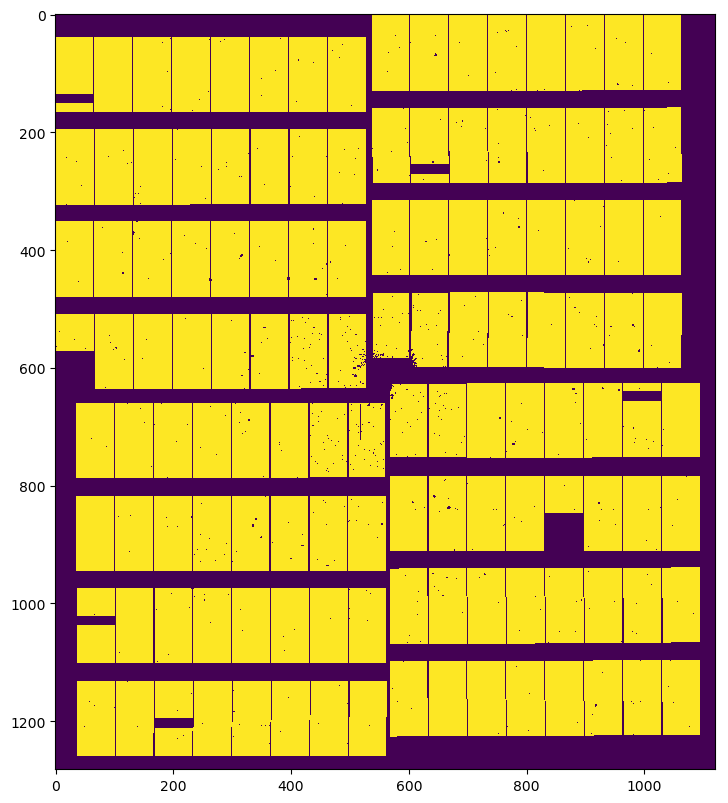

In [53]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(msk_good)
plt.show()

In [54]:
dark_mean[np.isnan(dark_mean)] = 0

In [55]:
dark_std[np.isnan(dark_std)] = 0

In [95]:
cid = 11

In [96]:
img = utils.assemble(dark_mean[cid], path_to_geometry + "b1.geom")
mimg = np.ma.masked_array(img, mask=1-msk_active)
mimg.data[mimg.data==0] = 1e-10

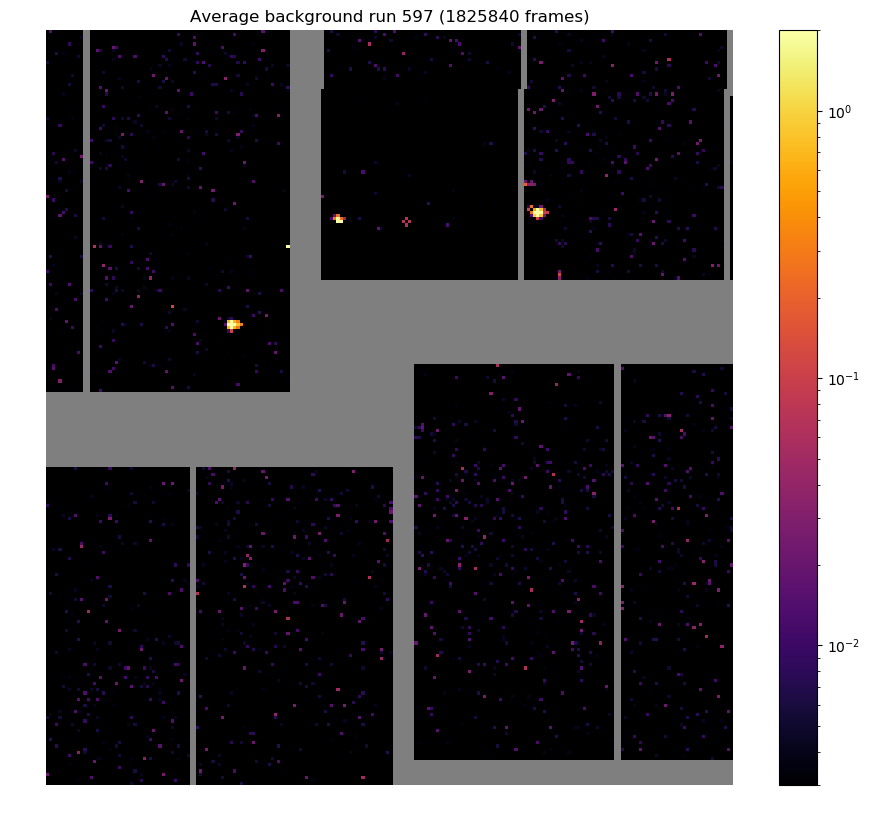

In [97]:
cx = 450
cy = 520
cmap = cm.get_cmap('inferno')
cmap.set_bad('0.5')
cmap.set_under('0.0')
plt.figure(figsize=(12,10), dpi=100)
plt.title("Average background run %d (%d frames)" %(run, n))
plt.axis('off')
plt.imshow(mimg[cy:-cy,cx:-cx], norm=colors.LogNorm(vmin=3e-3, vmax=2), cmap=cmap)
plt.colorbar()
#plt.savefig("../plots/r%04d_background.png", bbox_inches='tight')
plt.show()

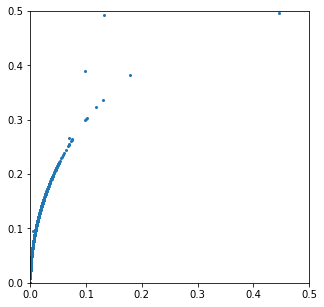

In [26]:
plt.figure(figsize=(5,5))
plt.plot(dark_mean[10,4].ravel(), dark_std[10,4].ravel(), lw=0, marker='.', ms=4)
#plt.hist2d(dark_mean[10,3].ravel(), dark_std[10,3].ravel(), range=([0,.1],[0,.1]), bins=100, norm=colors.LogNorm())
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.show()

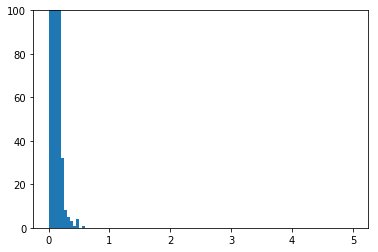

In [27]:
plt.hist(dark_std[10,4].ravel(), range=(0,5), bins=100)
plt.ylim(0,100)
plt.show()